# 65-alternate-shift-schedules-by-cell

## Background
High-Value machines can operate on different schedules, making off-shift time available for production. 

### Considerations
- have to build up inventory during the on-shift time to fill the machines during the off-shift time
- not having enough inventory before the end of the shift means there is a chance of starving the equipment in the off-shift time
- not producing enough in the off-shift can starve the mainline during the day

# Formulation

- any inventory that goes through the night shift has extra flow time
  - this would increase tooling requirements
- 

- Assume the nominal on-shift rate $\lambda_{on}$ is the same as the nominal off-shift rate $\lambda_{off}$ and is $\lambda_{cell}$
- Assume the production line has rate $\lambda_L$
- Assume operating time on-shift is $T_{on}$ and operating time off-shift is $T_{off}$
- overall rate is constrained by the rate of the off-shift cell:
$$ \lambda_L \leq \left( 1 + \frac{T_{off}}{T_{on}} \right) \lambda_{cell} $$

- the quantity $ \left( 1 + \frac{T_{off}}{T_{on}} \right) $ can be determined as a constant if all are inputs. necessary to be a GP.

- quantity at the beginning of the off-shift operations $Q_{in, off}$
  - build up produced by rate mismatch
- quantity produced during the off-shift work

- is there an opportunity for the optimizer to favorably starve the station in off-shift hours to reduce the inventory build up?
  - just have to make sure the off-shift quantity is accurate
- what is utilization calculated as?
  - compared to the line rate, utilization is more than 100%
  - or somehow calculate utilization of the total machine time?

__Reliability__
- in the on-shift, the rate of the downstream cell may be affected by starvation.

## Formulation using aggregate behavior

- probability that something is happening off-shift is
$$ \left( \frac{T_{off}}{T_{on} + T_{off}} \right) $$

### Inputs
- on-shift time $T_{on}$
- off-shitf time $T_{off}$

### Constraints
- average queueing time on and off shift is a function of the normal queueing time and the total offshift flow time:
$$ \bar{W_q} \geq \left( \frac{\rho}{\alpha}\right) \left(\frac{c_a^2 + c_s^2}{2} \right) \left( \frac{t_s}{mk} \right)+ T_{off} \left( \frac{T_{off}}{T_{on} + T_{off}} \right) $$

- the utilization of the cell is based on the additional capacity also available. Note, the quantity which would make this signomial if $T_{off}, T_{on}$ weren't inputs
$$ \lambda_{line} \leq \rho \frac{m}{t_s} \left( \frac{T_{on} + T_{off}}{T_{on}} \right) $$

- make sure there is engough inventory available at the end of the shift to support full off-shit production. Should be in the queue right before and right after the off-shift cell. This is applied for the entire production line. If there are multiple off-shift cells, the tooling requirement goes up as a sum of the total expected off-shift production.
$$ L \geq \left(\frac{m}{t_s}\right) T_{off} $$

- the quantity in the queues has to at least enough to support off-shift production for the queues before and after the off-shift cell
$$ L_{q,i} \geq \left(\frac{m}{t_s}\right) \left( \frac{T_{off}^2}{T_{on}} \right) $$

- needs to support it for the rate of the line
$$ \frac{L_{q,i}}{\lambda_{line}} = W_{q,i} \geq \frac{1}{\lambda_{line}} \left(\frac{m}{t_s}\right) \left( \frac{T_{off}^2}{T_{on}} \right) $$

- __INCORRECT!__ flow time through the leading and trailing queues has to be enough to support off-shift production
$$ W_{q,i} \geq \frac{T_{off}^2}{T_{on}} $$

- the queueing time at the trailing cell should also include the expected waiting time from the off-shift production



- variation of the off-shift process will go down thanks to aggregation effects of the off-shift work:
$$ c_s^2 \geq (c_s)^2 \left( \frac{T_{on}}{T_{off} + T_{on}} \right) $$

In [1]:
from gpkit import Variable, Model, units

In [2]:
from gpx.manufacturing import QNACell, FabLine
from gpx.primitives import Process

In [3]:

ton = Variable('T_{on}', 8, 'hrs', 'on shift time')
# ton = 12*units('hr')
toff = Variable('T_{off}', 8, 'hrs', 'off shift time')

In [4]:
p1 = Process(time=1*units('hr'), cv=1)
p2 = Process(time=2*units('hr'), cv=1)
p3 = Process(time=1*units('hr'), cv=1)

## Test at 0 Variability -- WORKS!!
# p1 = Process(time=1*units('hr'), cv=0.01)
# p2 = Process(time=2*units('hr'), cv=0.01)
# p3 = Process(time=1*units('hr'), cv=0.01)

In [5]:
c1 = QNACell(p1)
c2 = QNACell(p2)
c3 = QNACell(p3)

In [6]:
constr = []

In [7]:
# create substituion variable for process ratio
timeratio = Variable('\\frac{T_{on} + T_{off}}{T_{on}}', lambda m: (m[ton]+m[toff])/m[ton], '-', 'production ratio')
ptoff = Variable(
    # '\\left( \\frac{T_{off}}{T_{on} + T_{off}} \\right)',
    '\\text{Prob}[T_{off}]',
    lambda m: m[toff]/(m[ton] + m[toff]),
    '-',
    'probability of ending up off shift'
)

In [8]:
# add the off-shift cell constraints
constr.extend([
    c2.Wq >= c2.rho/c2.alpha*(c2.c2a + c2.c2s)/2*c2.tnu/c2.m + toff*ptoff/2.0,
    c2.c2d >= c2.alpha*c2.c2a + c2.rho*c2.c2s,
    1 >= c2.alpha + c2.rho,
    c2.lam <= c2.rho*c2.m/c2.tnu*timeratio,
    # c2.c2s >= c2.cvp**2,
    c2.c2s == p2.cv**2/timeratio,
    c2.W >= c2.Wq + c2.tnu,
    c2.tnu == p2.t,
])

In [9]:
# create a system
sys = FabLine([c1, c2, c3], return_cells=False)

In [10]:
# additional constraints for the flow time and total tooling
constr.extend([
    sys.L >= c2.m/c2.tnu*toff,  # system inventory to support off-shift production
    sys.L >= c2.m/c2.tnu*ton,   # system inventory to support on-shift production
    # c3.Wq >= c3.rho/c3.alpha*(c3.c2a + c3.c2s)/2*c3.tnu/c3.m + toff*ptoff/2.0, # waiting off shift
    c3.Wq >= c3._get_wq_basis() + toff*ptoff/2.0
])

In [11]:
# extend constraints with the models
constr.extend([
    c1,
    c3,
    sys,
    p1,p2,p3,
])

In [12]:
# cost = 1/sys.lam*10/units('hr')*units('count') + sys.L
# cost = 1/sys.lam

prodqty = Variable('N_{production}', 'count', 'daily production quantity')

constr.append(prodqty <= sys.lam*ton)

# maximize daily quantity
cost = 1/prodqty*100 + c2.m

In [13]:
m = Model(cost, constr)

In [14]:
# update substitions
m.substitutions.update({
    c1.m : 1,
    c2.m : 1,
    c3.m : 1,
    toff : 12*units('hr'),
    ton : 12*units('hr'),
    sys.L : 20,
})

In [15]:
m.substitutions

{FabLine.L: 20,
 QNACell.\chi_{cv}: 1,
 QNACell.\eta_t: 1,
 QNACell.m: 1,
 QNACell1.m: 1,
 QNACell2.\chi_{cv}: 1,
 QNACell2.\eta_t: 1,
 QNACell2.m: 1,
 T_{off}: 12,
 T_{on}: 12,
 \frac{T_{on} + T_{off}}{T_{on}}: <function __main__.<lambda>(m)>,
 \text{Prob}[T_{off}]: <function __main__.<lambda>(m)>}

In [16]:
m

<gpkit.Model object containing 17 top-level constraint(s) and 47 variable(s)>

In [17]:
print(m.solve().table())

Using solver 'mosek_cli'
 for 33 free variables
  in 46 posynomial inequalities.
Solving took 0.0264 seconds.

Optimal Cost
------------
 11.2

Free Variables
--------------
N_{production} : 9.804   [count]    daily production quantity

               | FabLine
             W : 24.48   [hr]       Total flow time
       \lambda : 0.817   [count/hr] Line Continuous Production Rate

               | Process1
        \sigma : 60      [min]      standard deviation of process time

               | Process2
        \sigma : 120     [min]      standard deviation of process time

               | Process3
        \sigma : 60      [min]      standard deviation of process time

               | QNACell
             W : 317.8   [min]      Total flow time through cell
            Wq : 257.8   [min]      Expected queueing time
        \alpha : 0.183              (1-rho)
       \lambda : 0.817   [count/hr] Production rate
           c2a : 0.9248             Arrival coefficient of variation squared
 

### Sweep the off-shift time

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
off_shift = np.linspace(1,24,24)

In [20]:
sol = m.sweep({toff : off_shift})

Sweeping over 24 solves.
Sweeping took 0.889 seconds.


In [21]:
rates = sol['cost']

In [22]:
sol(prodqty).magnitude

array([6.18063489, 6.62559381, 7.06123524, 7.48577086, 7.89610026,
       8.28854963, 8.65858228, 8.99761912, 9.29040363, 9.52514363,
       9.69546257, 9.80409348, 9.86084633, 9.8772882 , 9.86304555,
       9.8250181 , 9.76779744, 9.69443491, 9.60696158, 9.50679684,
       9.39506921, 9.27273153, 9.14070942, 9.0000038 ])

In [23]:
rates

array([17.17957, 16.09299, 15.16183, 14.35868, 13.66448, 13.06484,
       12.54924, 12.11405, 11.76379, 11.49853, 11.3141 , 11.19982,
       11.14111, 11.12424, 11.13886, 11.1781 , 11.23772, 11.31519,
       11.40912, 11.51879, 11.64388, 11.78431, 11.94007, 12.11111])

/home/user/aa-refactor/aa-venv/py3-dev/venv/lib/python3.5/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


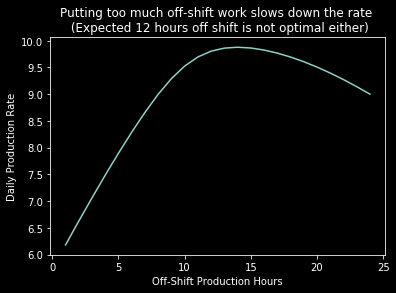

In [24]:
plt.plot(off_shift, sol(prodqty))
plt.title('Putting too much off-shift work slows down the rate \n (Expected 12 hours off shift is not optimal either)')
plt.xlabel('Off-Shift Production Hours')
plt.ylabel('Daily Production Rate')
plt.show()

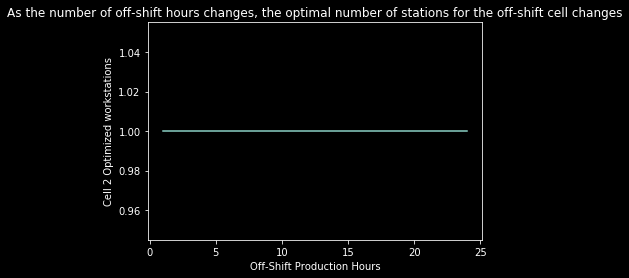

In [25]:
# if we are also optimizing the number of stations
plt.plot(off_shift, sol(c2.m))
plt.title('As the number of off-shift hours changes, the optimal number of stations for the off-shift cell changes')
plt.xlabel('Off-Shift Production Hours')
plt.ylabel('Cell 2 Optimized workstations')
plt.show()